In [1]:
import pennylane as qml
import numpy as np
import functools

In [2]:
def my_quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(y, wires=1)
    return qml.expval(qml.PauliZ(1))

In [3]:
dev = qml.device('default.qubit', wires=2, shots=1000)

In [4]:
circuit = qml.QNode(my_quantum_function, dev)

In [5]:
circuit(np.pi/4, 0.7)

tensor(0.776, requires_grad=True)

In [6]:
print(qml.draw(circuit)(np.pi/4, 0.7))

0: ──RZ(0.79)─╭●───────────┤     
1: ───────────╰X──RY(0.70)─┤  <Z>


(<Figure size 600x300 with 1 Axes>, <Axes:>)

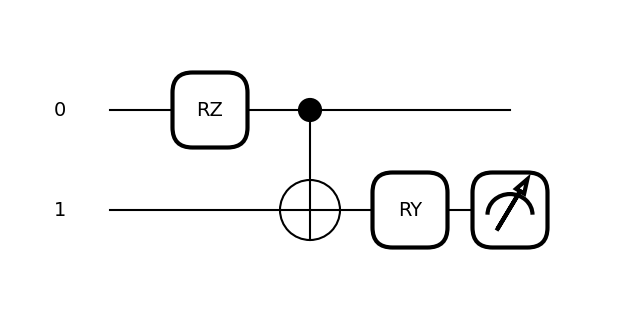

In [7]:
qml.draw_mpl(circuit)(np.pi/4, 0.7)

# Define circuit with decorator

In [8]:
dev = qml.device('default.qubit', wires=1, shots=1000)

In [9]:
@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    return qml.expval(qml.PauliZ(0))

In [10]:
circuit(np.pi/2)

tensor(0.016, requires_grad=True)

# Custom equal to RX

In [11]:
class MyRX(qml.operation.Operation):
    r"""
    The single qubit X rotation

    .. math:: R_x(\phi) = e^{-i\phi\sigma_x/2} = \begin{bmatrix}
                \cos(\phi/2) & -i\sin(\phi/2) \\
                -i\sin(\phi/2) & \cos(\phi/2)
            \end{bmatrix}.

    **Details:**

    * Number of wires: 1
    * Number of parameters: 1
    * Number of dimensions per parameter: (0,)
    * Gradient recipe: :math:`\frac{d}{d\phi}f(R_x(\phi)) = \frac{1}{2}\left[f(R_x(\phi+\pi/2)) - f(R_x(\phi-\pi/2))\right]`
      where :math:`f` is an expectation value depending on :math:`R_x(\phi)`.

    Args:
        phi (float): rotation angle :math:`\phi`
        wires (Sequence[int] or int): the wire the operation acts on
        do_queue (bool): Indicates whether the operator should be
            immediately pushed into the Operator queue (optional)
        id (str or None): String representing the operation (optional)
    """
    num_wires = 1
    num_params = 1
    """int: Number of trainable parameters that the operator depends on."""

    ndim_params = (0,)
    """tuple[int]: Number of dimensions per trainable parameter that the operator depends on."""

    basis = "X"
    grad_method = "A"
    parameter_frequencies = [(1,)]

    def __init__(self, phi, wires, do_queue=True, id=None):
        super().__init__(phi, wires=wires, do_queue=do_queue, id=id)

    @staticmethod
    def compute_matrix(theta):  # pylint: disable=arguments-differ
        r"""Representation of the operator as a canonical matrix in the computational basis (static method).

        The canonical matrix is the textbook matrix representation that does not consider wires.
        Implicitly, this assumes that the wires of the operator correspond to the global wire order.

        .. seealso:: :meth:`~.RX.matrix`

        Args:
            theta (tensor_like or float): rotation angle

        Returns:
            tensor_like: canonical matrix

        **Example**

        >>> qml.RX.compute_matrix(torch.tensor(0.5))
        tensor([[0.9689+0.0000j, 0.0000-0.2474j],
                [0.0000-0.2474j, 0.9689+0.0000j]])
        """

        stack_last = functools.partial(qml.math.stack, axis=-1)

        c = qml.math.cos(theta / 2)
        s = qml.math.sin(theta / 2)

        if qml.math.get_interface(theta) == "tensorflow":
            c = qml.math.cast_like(c, 1j)
            s = qml.math.cast_like(s, 1j)

        # The following avoids casting an imaginary quantity to reals when backpropagating
        c = (1 + 0j) * c
        js = -1j * s
        return qml.math.stack([stack_last([c, js]), stack_last([js, c])], axis=-2)

In [12]:
@qml.qnode(dev)
def circuit(x):
    MyRX(x, wires=0)
    return qml.expval(qml.PauliZ(0))

In [13]:
circuit(np.pi/2)

tensor(0.012, requires_grad=True)

# Custom Rxix

In [14]:
class RXIX(qml.operation.Operation):
    r"""
    The custom 3 qubit operation

    .. math:: R_{xix}(\phi) = e^{-i\frac{\phi}{2}(\sigma_x\otimes I\otimes\sigma_x)}.

    **Details:**

    * Number of wires: 3
    * Number of parameters: 1
    * Number of dimensions per parameter: (0,)
    * Gradient recipe: :math:`\frac{d}{d\phi}f(R_x(\phi)) = \frac{1}{2}\left[f(R_x(\phi+\pi/2)) - f(R_x(\phi-\pi/2))\right]`
      where :math:`f` is an expectation value depending on :math:`R_x(\phi)`.

    Args:
        phi (float): rotation angle :math:`\phi`
        wires (Sequence[int] or int): the wire the operation acts on
        do_queue (bool): Indicates whether the operator should be
            immediately pushed into the Operator queue (optional)
        id (str or None): String representing the operation (optional)
    """
    num_wires = 3
    num_params = 1
    """int: Number of trainable parameters that the operator depends on."""

    ndim_params = (0,)
    """tuple[int]: Number of dimensions per trainable parameter that the operator depends on."""

    # basis = "X"
    grad_method = "A"
    parameter_frequencies = [(1,)]

    def __init__(self, phi, wires, do_queue=True, id=None):
        super().__init__(phi, wires=wires, do_queue=do_queue, id=id)

    @property
    def num_params(self):
        # if it is known before creation, define the number of parameters to expect here,
        # which makes sure an error is raised if the wrong number was passed
        return 1

    @staticmethod
    def compute_matrix(theta):  # pylint: disable=arguments-differ
        r"""Representation of the operator as a canonical matrix in the computational basis (static method).

        The canonical matrix is the textbook matrix representation that does not consider wires.
        Implicitly, this assumes that the wires of the operator correspond to the global wire order.

        .. seealso:: :meth:`~.RX.matrix`

        Args:
            theta (tensor_like or float): rotation angle

        Returns:
            tensor_like: canonical matrix

        **Example**

        >>> qml.RX.compute_matrix(torch.tensor(0.5))
        tensor([[0.9689+0.0000j, 0.0000-0.2474j],
                [0.0000-0.2474j, 0.9689+0.0000j]])
        """

        stack_last = functools.partial(qml.math.stack, axis=-1)

        c = qml.math.cos(theta / 2)
        s = qml.math.sin(theta / 2)
        o = 0

        if qml.math.get_interface(theta) == "tensorflow":
            c = qml.math.cast_like(c, 1j)
            s = qml.math.cast_like(s, 1j)
            o = qml.math.cast_like(o, 1j)

        # The following avoids casting an imaginary quantity to reals when backpropagating
        c = (1 + 0j) * c
        js = -1j * s
        o = (1 + 0j) * o

        return qml.math.stack([
            stack_last([c, o, o, o, o, js, o, o]),
            stack_last([o, c, o, o, js, o, o, o]),
            stack_last([o, o, c, o, o, o, o, js]),
            stack_last([o, o, o, c, o, o, js, o]),
            stack_last([o, js, o, o, c, o, o, o]),
            stack_last([js, o, o, o, o, c, o, o]),
            stack_last([o, o, o, js, o, o, c, o]),
            stack_last([o, o, js, o, o, o, o, c])
        ], axis=-2)

In [15]:
dev = qml.device('default.qubit', wires=3, shots=1000)

In [16]:
@qml.qnode(dev)
def circuit(x):
    RXIX(x, wires=[0,1,2])
    return qml.expval(qml.PauliZ(0))

In [17]:
circuit(np.pi/2)

tensor(-0.032, requires_grad=True)